In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [21]:
columns=inspector.get_columns('measurement')
for c in columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [22]:
columns=inspector.get_columns('station')
for c in columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [34]:
start_date=dt.datetime(2016,8,23)
end_date=dt.datetime(2017,8,23)

In [35]:
sel=[Measurement.date,
    Measurement.prcp]
year_data=session.query(*sel).\
        filter(func.strftime(Measurement.date>=start_date,Measurement.date<=end_date)).\
        order_by(Measurement.date).all()
year_data

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

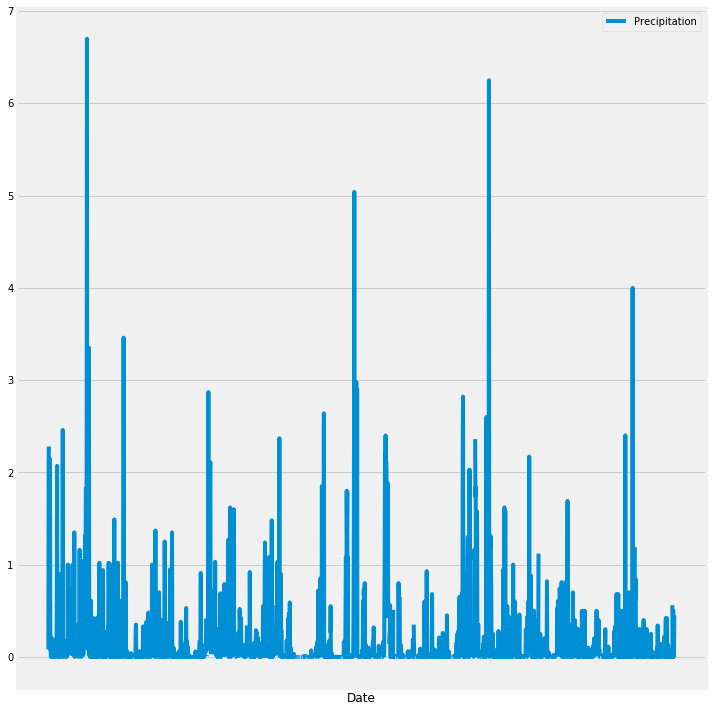

<Figure size 432x288 with 0 Axes>

In [117]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(year_data,columns=['Date','Precipitation'])
df.set_index('Date',inplace=True)
df.plot(figsize=(10,10))
plt.xticks([])
plt.tight_layout()
plt.show()
plt.savefig('Weather_analysis_images/Precipitation.png')

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [66]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [83]:
# What are the most active stations? (i.e. what stations have the most rows)?
sel1=[Measurement.station,
    func.count(Measurement.station)]
# List the stations and the counts in descending order.
temp=session.query(*sel1).\
        group_by(Measurement.station).\
        order_by((func.count(Measurement.station)).desc()).all()
temp

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [88]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_obv=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
            filter(Measurement.station=="USC00519281").all()
            
station_obv

[(54.0, 85.0, 71.66378066378067)]

In [123]:
year_tobs=session.query(Measurement.tobs).\
        filter(Measurement.station=="USC00519281").\
        filter(func.strftime(Measurement.date>=start_date,Measurement.date<=end_date)).\
        order_by(Measurement.tobs).all()


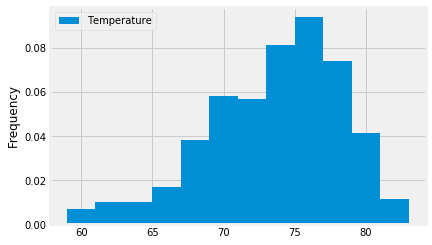

<Figure size 432x288 with 0 Axes>

In [126]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_tobs=pd.DataFrame(year_tobs,columns=['Temperature'])

df_tobs.plot.hist(normed=True,bins=12)

plt.show()
plt.savefig('Weather_analysis_images/histogram.png')

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):    
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
print(calc_temps('2017-02-28', '2017-03-01'))

[(64.0, 70.64285714285714, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start=dt.date(2017,12,25)-dt.timedelta(days=365)
trip_end_date=trip_start+dt.timedelta(days=15)
temp_trip_data=calc_temps(trip_start,trip_end_date)
print(temp_trip_data)

[(60.0, 69.73195876288659, 78.0)]


In [135]:
triptemp=list(np.ravel(temp_trip_data))
Tmin=triptemp[0]
T_avg=triptemp[1]
Tmax=triptemp[2]

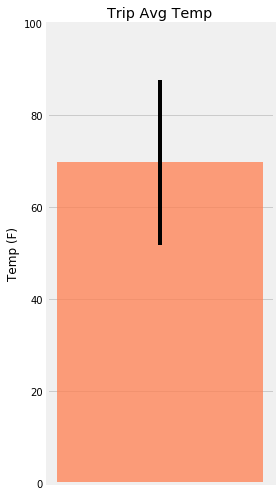

In [155]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#fig,ax=plt.subplots()
#x=range(len(triptemp))
plt.figure(figsize=(4,7))
plt.bar(1,T_avg,color='coral',alpha=0.75)
plt.errorbar(1,T_avg,yerr=(Tmax-Tmin),color='k')
plt.ylim(0,100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.savefig('Weather_analysis_images/triptemp.png')

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
queries=session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
        filter(Measurement.station==Station.station).\
        filter(Measurement.date>=trip_start).filter(Measurement.date<=trip_end_date).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
for rec in queries:
    
    print(rec)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 7.07)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.8700000000000003)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.77)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.6400000000000001)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.85)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21000000000000002)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


## Optional Challenge Assignment

In [76]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
   
    sel3 = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel3).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [85]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Loop through the list of %m-%d strings and calculate the normals for each date

    


In [84]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


<IPython.core.display.Javascript object>


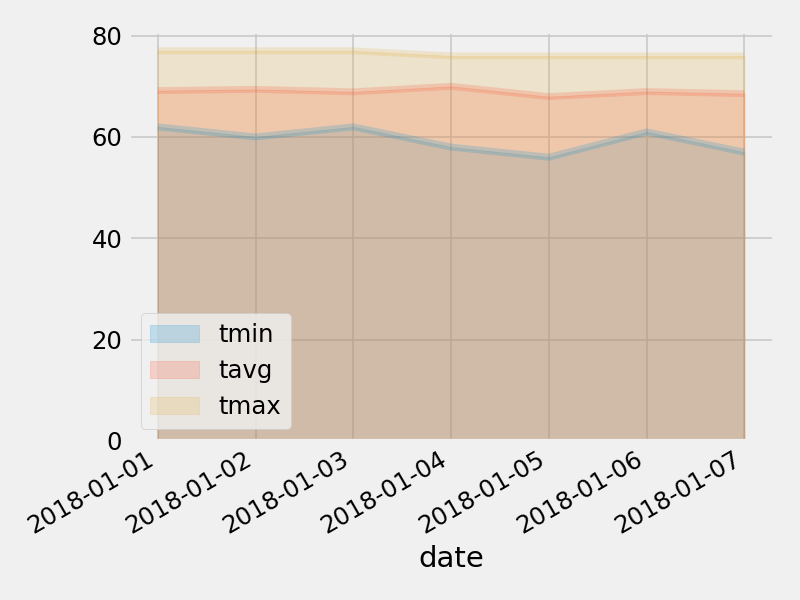

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
